# Model fitting
What we usually call inversion and that we solve by the standard least squares method is much more profound. For instance, why do you minimize the $\chi^2$ when you want to fit the Stokes profiles? In this short notebook I will explain why you do what you do when using any inversion code.

The following are the four fundamental steps you need to take to succeed:

 - You have to understand your problem: variables, assumptions, etc.
 - You have to understand the model that 'generates' your data
 - If you understand how your data is generated, then you are automatically able to define a merit function
 - The 'best' fit is the one that minimizes this merit function

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import pymc3 as pm
import theano.tensor as tt
pm.__version__

'3.4.1'

## Writing the generative model

This is usually the most important, and often the most complex, part of any inference. Although what I explain here extends to nonlinear problems, let's see the fundamentals with the aid of a linear model.

Let us assume that our data has been generated from a latent straight line with some added uncertainty:

$$ y_i = \alpha x_i + \beta + \epsilon_i$$
$$ \epsilon_i \sim \mathrm{N}(0, \sigma_i^2)$$

The uncertainty has a Gaussian distribution with zero mean and diagonal covariance. Potentially each $y_i$ can have a different uncertainty, but let's assume that all $\sigma_i$ are equal. Given this uncertainty, there is not a single value for $\alpha$ and $\beta$ that fulfill the previous equation. Consequently, any inference problem is probabilistic in nature. We need to compute the probability distribution for the model parameters, in our case $p(\alpha,\beta|D)$, where $D$ is all the data we have.

Additionally, we assume that $x_i$ is given with zero uncertainty (this is always not the case, but a good approximation in spectropolarimetric inversions). 

### A simple case

In [2]:
n_points = 30
sigma_noise = 0.5
x_trend = np.linspace(0,5,n_points)
y_trend = 1.2 * x_trend + 0.5 + sigma_noise*np.random.randn(n_points)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


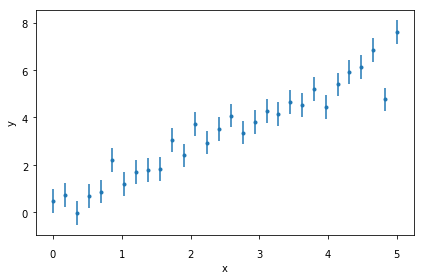

In [3]:
f, ax = pl.subplots()
ax.plot(x_trend, y_trend, marker='.',linestyle='none')
ax.errorbar(x_trend, y_trend, yerr=sigma_noise, color='C0', linestyle='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
pl.show()

Once the generative model is defined, this automatically defines the merit function. This merit function is the likelihood, and gives the probability that the data has been generated with a certain combination of model parameters. Given that we assumed that our observations were extracted from a zero mean, diagonal covariance Gaussian, the likelihood is given precisely by this function:

$$ \mathcal{L} = p(D|\alpha,\beta) = \prod_{i=1}^{N} \mathrm{N}(y_i|\alpha x_i + \beta,\sigma^2)$$

where we factorize the multivariate normal because the covariance matrix is diagonal.

However, since we want to get information about the model parameters we need to apply the Bayes theorem, to relate the posterior distribution $p(\alpha,\beta|D)$ and the likelihood:

$$p(\alpha,\beta|D) = \frac{p(D|\alpha,\beta) p(\alpha,\beta)}{p(D)}$$

where $p(\alpha,\beta)$ encode our prior information. Under the assumption of flat priors, the posterior and the likelihood become the same thing up to a constant. Now, let's take logarithm in both sizes (we can take it because the log is a monotonic function) and then:

$$ \log p(\alpha,\beta|D) = -\frac{N}{2} \log 2\pi - N \log \sigma - \sum_{i=1}^{N} \frac{(y_i - \alpha x_i - \beta)^2}{2\sigma^2}$$

which is the proportional to the standard $\chi^2$: $\log p(\alpha,\beta|D) \propto \chi^2/2$

Let's use the pymc3 Bayesian inference package to find the value that maximizes the posterior:

In [4]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=-5,upper=5)
    beta = pm.Uniform('beta', lower=-5,upper=5)
    y = alpha * x_trend + beta
    Y = pm.Normal('yobs', mu=y, sd=sigma_noise, observed=y_trend)

In [5]:
with model:
    map_estimate = pm.find_MAP()
    trace1 = pm.sample()

logp = -28.589, ||grad|| = 0.008627: 100%|██████████| 14/14 [00:00<00:00, 43.71it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2992.98draws/s]
The acceptance probability does not match the target. It is 0.8793608465071786, but should be close to 0.8. Try to increase the number of tuning steps.


The maximum a-posteriori (the one that maximizes the posterior or, equivalently, that minimizes the $\chi^2$ for flat priors) is:

In [6]:
map_estimate

{'alpha': array(1.26403281),
 'alpha_interval__': array(0.51681746),
 'beta': array(0.24524207),
 'beta_interval__': array(0.09817561)}

very similar to the original values of $\alpha=1.2$ and $\beta=0.5$. Now, let's see what happens if we sample the full posterior and also compute marginal posteriors ($p(\alpha|D)$ and $p(\beta|D)$, computed by integrating the other variable), by also showing all fits that are compatible with the observations:

In [7]:
pm.summary(trace1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.264904,0.055586,0.001935,1.150419,1.365284,686.510282,1.000070
beta,0.242536,0.163084,0.006115,-0.083618,0.565003,636.405486,1.001981


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70e9829a58>,
      dtype=object)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


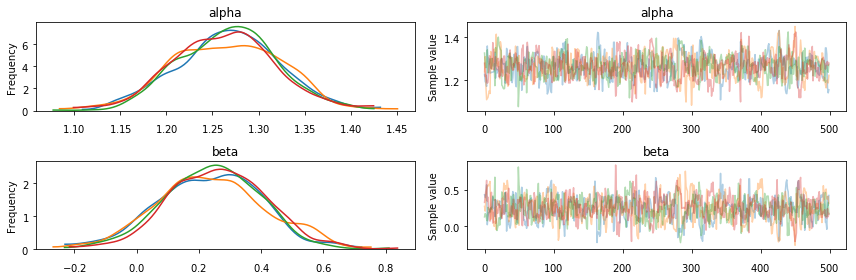

In [8]:
pm.traceplot(trace1)

In [9]:
y_syn = trace1['alpha'][:,None]*x_trend[None,:] + trace1['beta'][:,None]

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


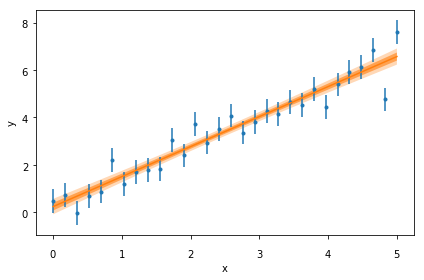

In [10]:
f, ax = pl.subplots()
ax.plot(x_trend, y_trend, marker='.',linestyle='none')
ax.errorbar(x_trend, y_trend, yerr=sigma_noise, color='C0', linestyle='none')
ax.set_xlabel('x')
ax.set_ylabel('y')

y_syn = trace1['alpha'][:,None]*x_trend[None,:] + trace1['beta'][:,None]

mean = np.mean(y_syn, axis=0)
std = np.std(y_syn, axis=0)

ax.plot(x_trend, mean, color='C1')
ax.fill_between(x_trend, mean-2*std, mean+2*std ,alpha=0.3, facecolor='C1')
ax.fill_between(x_trend, mean-std, mean+std ,alpha=0.6, facecolor='C1')
pl.show()

### A more complicated case
Let us assume that now the observations show a few outliers:

In [11]:
n_points = 30
sigma_noise = 0.5
x_trend = np.linspace(0,5,n_points)
y_trend = 1.2 * x_trend + 0.5 + sigma_noise*np.random.randn(n_points)
x_outliers = np.asarray([1,1.1,0.2,4.2])
y_outliers = np.asarray([8,6,4,3])
x_obs = np.append(x_trend, x_outliers)
y_obs = np.append(y_trend, y_outliers)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


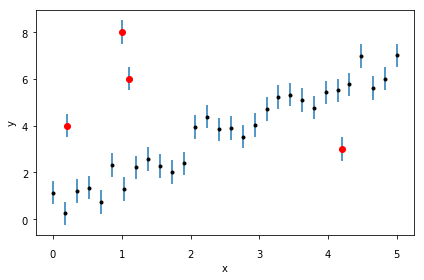

In [12]:
f, ax = pl.subplots()
ax.plot(x_trend, y_trend, marker='.',color='k',linestyle='none')
ax.plot(x_outliers, y_outliers, marker='o',color='r',linestyle='none')
ax.errorbar(x_obs, y_obs, yerr=sigma_noise, color='C0', linestyle='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
pl.show()

The standard way to proceed would be to handpick the outliers and remove them. If we do not do that, the inference produces biased results. Let's check that:

In [13]:
with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=-5,upper=5)
    beta = pm.Uniform('beta', lower=-5,upper=5)
    y = alpha * x_obs + beta
    Y = pm.Normal('yobs', mu=y, sd=sigma_noise, observed=y_obs)

In [14]:
with model:
    map_estimate2 = pm.find_MAP()
    trace2 = pm.sample()

logp = -146.74, ||grad|| = 0.021712: 100%|██████████| 14/14 [00:00<00:00, 2207.20it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2894.40draws/s]
The acceptance probability does not match the target. It is 0.8930168896613447, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8867506646215666, but should be close to 0.8. Try to increase the number of tuning steps.


In [15]:
print(map_estimate2)
pm.summary(trace2)

{'alpha_interval__': array(0.36333537), 'beta_interval__': array(0.71654684), 'alpha': array(0.89847593), 'beta': array(1.71846155)}


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.900824,0.054298,0.002097,0.795800,1.005343,574.542589,1.003735
beta,1.715974,0.152273,0.005990,1.418995,2.004504,563.340350,1.003470


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f70b5ddcf28>,
      dtype=object)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


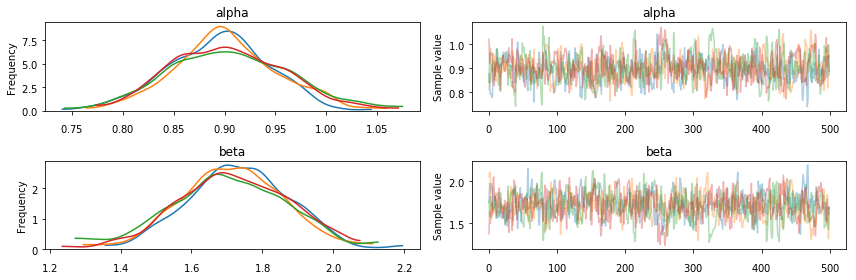

In [16]:
pm.traceplot(trace2)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


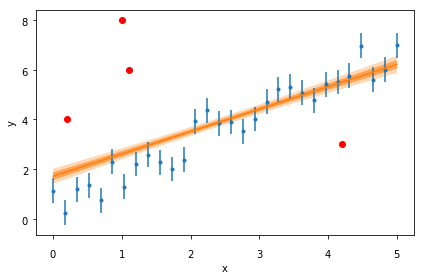

In [17]:
f, ax = pl.subplots()
ax.plot(x_trend, y_trend, marker='.',linestyle='none')
ax.plot(x_outliers, y_outliers, marker='o',color='r',linestyle='none')
ax.errorbar(x_trend, y_trend, yerr=sigma_noise, color='C0', linestyle='none')
ax.set_xlabel('x')
ax.set_ylabel('y')

y_syn = trace2['alpha'][:,None]*x_trend[None,:] + trace2['beta'][:,None]

mean = np.mean(y_syn, axis=0)
std = np.std(y_syn, axis=0)

ax.plot(x_trend, mean, color='C1')
ax.fill_between(x_trend, mean-2*std, mean+2*std ,alpha=0.3, facecolor='C1')
ax.fill_between(x_trend, mean-std, mean+std ,alpha=0.6, facecolor='C1')
pl.show()

How to fix it? As said, one can remove by hand the outliers, which are pretty obvious in this case. However, what happens when the outliers are not so obvious?

In this case, you should follow the original four points and model all your data. In our case, we will assume that the "good" data follows the straight line and that the outliers are extracted from a very broad Gaussian distribution:

$$
y_i(\mathrm{good}) = \alpha x_i + \beta + \epsilon_i \\
y_i(\mathrm{bad}) = Y_\mathrm{bad}+ e_i
$$

with $e_i \sim \mathrm{N}(0, V_\mathrm{bad})$. Each point has a certain probability of being good or bad. Under such assumptions, our likelihood becomes:

$$
p(D|\alpha,\beta,Y_\mathrm{bad},V_\mathrm{bad}) = \prod_{i=1}^N \gamma \mathrm{N}(y_i|\alpha x_i + \beta,\sigma^2) + (1-\gamma) \mathrm{N}(y_i|Y_\mathrm{bad},V_\mathrm{bad}^2)
$$

Sampling from this posterior, with appropriate priors, give the following results:

In [18]:
n = len(x_obs)

with pm.Model() as model:
    alpha = pm.Uniform('alpha', lower=-5,upper=5)
    beta = pm.Uniform('beta', lower=-5,upper=5)
    
    Ybad = pm.Uniform('YBad', lower=-5, upper=15)
    Vbad = pm.Gamma('VBad', alpha=0.01, beta=0.01)
    
    y = alpha * x_obs + beta
    
    mu = tt.stack([y, Ybad*np.ones(n)], axis=1)
    sd = tt.stack([sigma_noise, Vbad], axis=1)
    
    w = pm.Dirichlet('w', a=np.array([1, 1]))

    like = pm.NormalMixture('like', w=w, mu=mu, sd=sd, observed=y_obs)

In [19]:
with model:
    map_estimate3 = pm.find_MAP()
    trace3 = pm.sample()

logp = -53.507, ||grad|| = 0.72349: 100%|██████████| 38/38 [00:00<00:00, 970.23it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, VBad, YBad, beta, alpha]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 931.14draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f708e60ab38>,
      dtype=object)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


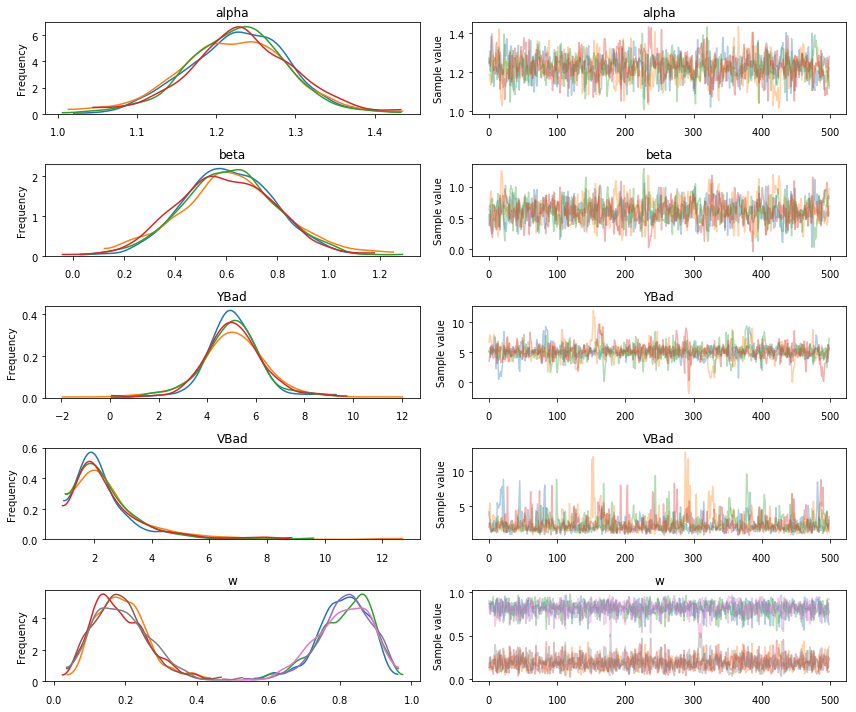

In [20]:
pm.traceplot(trace3)

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


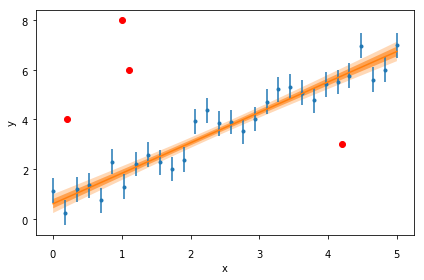

In [21]:
f, ax = pl.subplots()
ax.plot(x_trend, y_trend, marker='.',linestyle='none')
ax.plot(x_outliers, y_outliers, marker='o',color='r',linestyle='none')
ax.errorbar(x_trend, y_trend, yerr=sigma_noise, color='C0', linestyle='none')
ax.set_xlabel('x')
ax.set_ylabel('y')

y_syn = trace3['alpha'][:,None]*x_trend[None,:] + trace3['beta'][:,None]

mean = np.mean(y_syn, axis=0)
std = np.std(y_syn, axis=0)

ax.plot(x_trend, mean, color='C1')
ax.fill_between(x_trend, mean-2*std, mean+2*std ,alpha=0.3, facecolor='C1')
ax.fill_between(x_trend, mean-std, mean+std ,alpha=0.6, facecolor='C1')
pl.show()